In [116]:
import glob
from os.path import abspath 
import json

import pandas as pd 
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# --- open several .csv files
def get_data(path):
    df_group = [pd.read_pickle(i_path) for i_path in glob.glob(path)]
    return pd.concat(df_group)

# --- unzip non-dominated results into rows
def explode_ndf(df):
    df['zip'] = df[['ndf_f', 'ndf_x']].apply(lambda row: list(zip(*row.values)), axis=1)
    df.drop(['ndf_f', 'ndf_x'], axis=1, inplace=True)
    df = df.explode('zip')
    
    df = pd.concat([df.reset_index(drop=True), 
               pd.DataFrame.from_records(df['zip'].values, columns=['obj', 'params'])],
              axis=1).drop('zip', 1)
    
    # --- column for each objective     
    obj_df = pd.DataFrame.from_records(df['obj'].values, columns=df['objectives'].iloc[0])
    df = pd.concat([df.reset_index(drop=True), obj_df],
          axis=1).drop(['obj', 'objectives'], 1)

    return df

In [117]:
df = get_data("results_paper/*/separate(GradientBoostingRegressor+GradientBoostingRegressor)_2_RF.*.pkl")
df = explode_ndf(df)
df

,iteration,problem,feature_dim,ndf_size,i_time,model_id,params,test_roc_auc,fit_time
0,1,separate(GradientBoostingRegressor+GradientBoo...,7,5,61.787316,140530455263408,"[gini, 38.0, 0.3125, 0.34375, 0.28125, sqrt, 71]",0.500000,0.197894
1,1,separate(GradientBoostingRegressor+GradientBoo...,7,5,61.787316,140530455263408,"[gini, 42.0, 0.05774712412520383, 0.2560560628...",0.548132,0.126918
2,1,separate(GradientBoostingRegressor+GradientBoo...,7,5,61.787316,140530455263408,"[gini, 42.0, 0.05774712412520383, 0.3143623135...",0.552008,0.115395
3,1,separate(GradientBoostingRegressor+GradientBoo...,7,5,61.787316,140530455263408,"[gini, 60.0, 0.45112883103513207, 0.2419068902...",0.523755,0.074305
4,1,separate(GradientBoostingRegressor+GradientBoo...,7,5,61.787316,140530455263408,"[gini, 42.0, 0.05774712412520383, 0.3143623135...",0.541719,0.126498
...,...,...,...,...,...,...,...,...,...
8325,98,separate(GradientBoostingRegressor+GradientBoo...,7,2,4399.210938,139834177103984,"[gini, 14.679577778933911, 0.7823783387619042,...",0.500000,0.015325
8326,99,separate(GradientBoostingRegressor+GradientBoo...,7,2,4443.154341,139834177103984,"[gini, 59.27111612862842, 0.7279771122430649, ...",0.500000,0.015357
8327,99,separate(GradientBoostingRegressor+GradientBoo...,7,2,4443.154341,139834177103984,"[gini, 14.679577778933911, 0.7823783387619042,...",0.500000,0.015325
8328,100,separate(GradientBoostingRegressor+GradientBoo...,7,2,4487.441177,139834177103984,"[gini, 59.27111612862842, 0.7279771122430649, ...",0.500000,0.015357


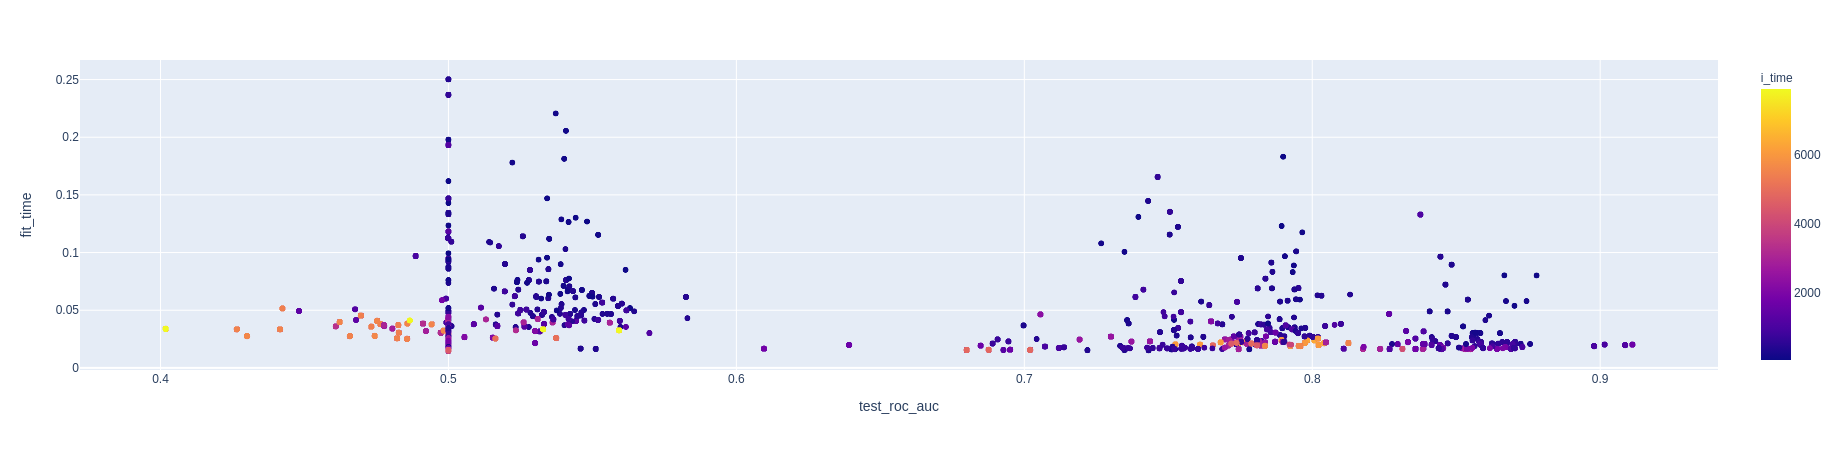

In [118]:
px.scatter(df, x="test_roc_auc", y="fit_time", color="i_time")

<AxesSubplot:xlabel='test_roc_auc', ylabel='fit_time'>

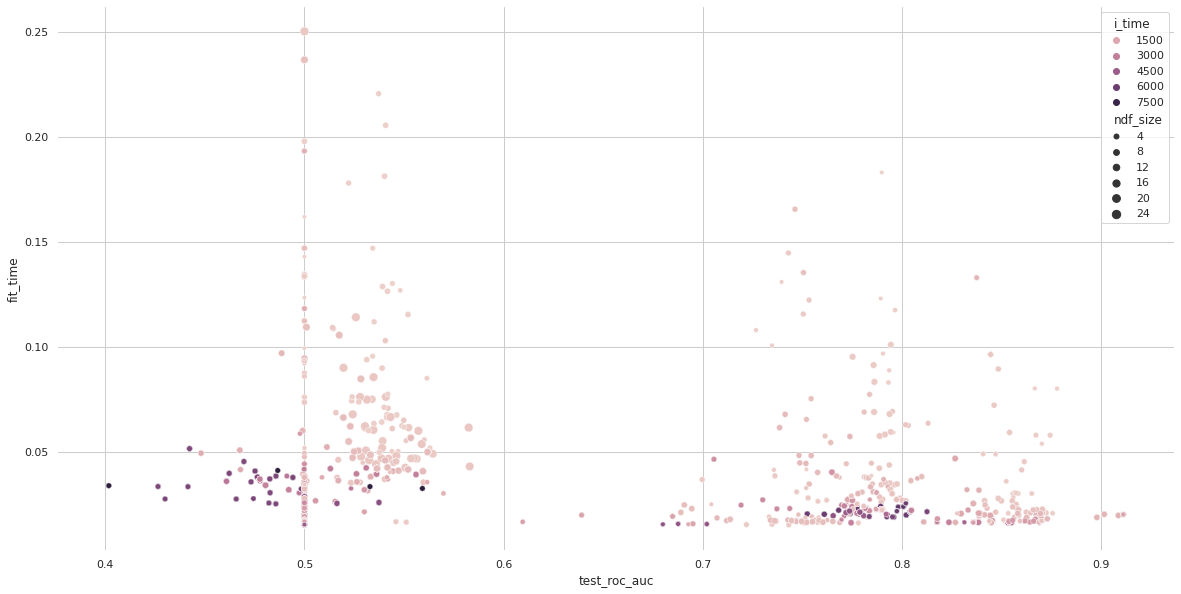

In [119]:
f, ax = plt.subplots(figsize=(20, 10))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="test_roc_auc", y="fit_time",
                hue="i_time", size="ndf_size",
                data=df, ax=ax)

## Final results: all samples

In [120]:
data = get_data("results_paper/open_ml_1049/dataset.*.pkl")
data

,criterion,max_depth,min_samples_split,min_samples_leaf,min_weight_fraction_leaf,max_features,n_estimators,fit_time,score_time,test_f1,test_roc_auc
0,gini,61.000000,0.500000,0.250000,0.250000,sqrt,505,0.904406,0.131023,0.000000,0.857405
1,entropy,31.000000,0.750000,0.125000,0.375000,sqrt,752,1.674720,0.219262,0.000000,0.500000
2,gini,90.000000,0.250000,0.375000,0.125000,log2,257,0.533135,0.079966,0.000000,0.500000
3,gini,46.000000,0.625000,0.062500,0.437500,log2,133,0.298505,0.043292,0.000000,0.840916
4,entropy,105.000000,0.125000,0.312500,0.187500,sqrt,628,1.325144,0.176702,0.000000,0.794443
...,...,...,...,...,...,...,...,...,...,...,...
1005,gini,72.779428,0.001068,0.013055,0.011010,sqrt,13,0.025971,0.007744,0.327123,0.926379
1006,gini,15.003550,0.001068,0.434228,0.000937,log2,13,0.019353,0.007256,0.000000,0.500000
1007,gini,81.013923,0.001255,0.000385,0.010731,log2,13,0.025953,0.007720,0.324719,0.903323
1008,entropy,81.013923,0.001255,0.013055,0.000938,log2,135,0.256632,0.031982,0.201794,0.921559


<AxesSubplot:xlabel='test_roc_auc', ylabel='fit_time'>

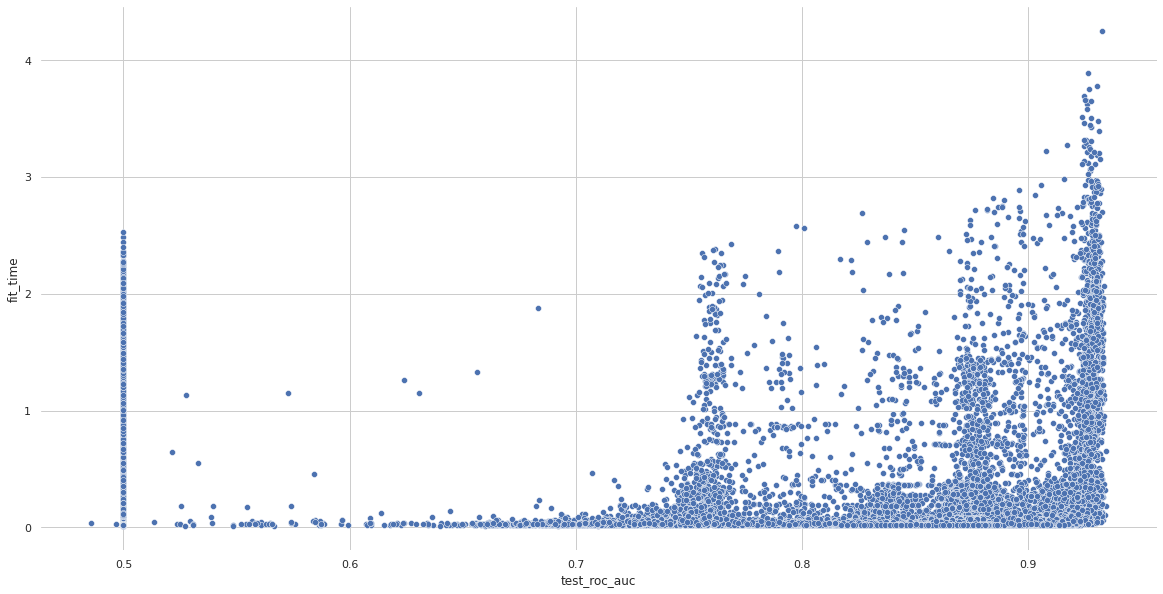

In [121]:
f, ax = plt.subplots(figsize=(20, 10))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="test_roc_auc", y="fit_time",
                data=data, ax=ax)